In [32]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.discretisation import DecisionTreeDiscretiser


In [39]:
data = pd.read_csv('titanic.csv')

In [40]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data[['Age', 'Fare']],
    data['Survived'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape


((623, 2), (268, 2))

In [41]:
def impute_na(data, variable):
    df = data.copy()
    
    # random sampling
    df[variable+'_random'] = df[variable]
    # extract the random sample to fill the na
    random_sample = X_train[variable].dropna().sample(df[variable].isnull().sum(), random_state=0)
    # pandas needs to have the same index in order to merge datasets
    random_sample.index = df[df[variable].isnull()].index
    df.loc[df[variable].isnull(), variable+'_random'] = random_sample
    
    return df[variable+'_random']

In [42]:
# replace NA in both train and test sets

X_train['Age'] = impute_na(X_train, 'Age')
X_test['Age'] = impute_na(X_test, 'Age')

X_train['Fare'] = impute_na(X_train, 'Fare')
X_test['Fare'] = impute_na(X_test, 'Fare')


### Age

In [43]:
X_train.head(5)

,Age,Fare
857,51.0,26.5500
52,49.0,76.7292
386,1.0,46.9000
124,54.0,77.2875
578,16.0,14.4583


In [45]:
# example: build Classification tree using Age to predict Survived

tree_model = DecisionTreeClassifier(max_depth=3)

tree_model.fit(X_train['Age'].to_frame(), y_train)

X_train['Age_tree'] = tree_model.predict_proba(X_train['Age'].to_frame())[:,1]

X_train.head(10)

,Age,Fare,Age_tree
857,51.0,26.5500,0.465517
52,49.0,76.7292,0.465517
386,1.0,46.9000,0.411765
124,54.0,77.2875,0.465517
578,16.0,14.4583,0.366337
549,8.0,36.7500,0.642857
118,24.0,247.5208,0.366337
12,20.0,8.0500,0.366337
157,30.0,8.0500,0.366337
127,24.0,7.1417,0.366337


In [46]:
# let's explore how many end points the tree created

X_train['Age_tree'].unique()

array([0.46551724, 0.41176471, 0.36633663, 0.64285714, 0.        ,
       1.        , 0.5       ])

Text(0, 0.5, 'Survived')

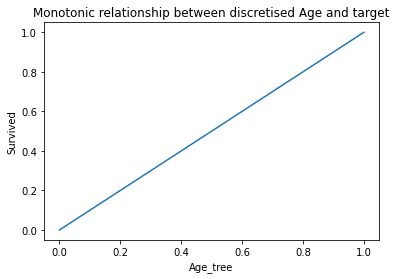

In [48]:
# monotonic relationship with target

pd.concat([X_train, y_train], axis=1).groupby(['Age_tree'])['Survived'].mean().plot()
plt.title('Monotonic relationship between discretised Age and target')
plt.ylabel('Survived')



<AxesSubplot:xlabel='Age_tree'>

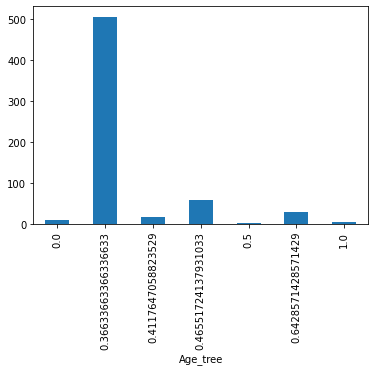

In [49]:
# number of passengers per probabilistic bucket / bin

X_train.groupby(['Age_tree'])['Age'].count().plot.bar()



<AxesSubplot:xlabel='Age_tree'>

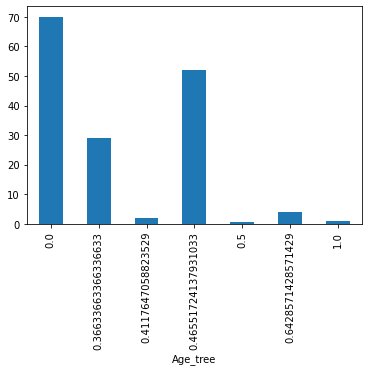

In [51]:
# median age within each bucket originated by the tree

X_train.groupby(['Age_tree'])['Age'].median().plot.bar()


#### Discretisation with Decision Trees using Feature-Engine